# Bee Detection: Data Balancing with Augmentation

## Overview
This project trains models to detect worker bees and drone bees. The dataset initially suffers from severe class imbalance, which we address through targeted augmentation techniques.

## Workflow

### 1. Setup and Installation
In the first section, install the necessary packages.

### 2. Load Dataset from Roboflow
load the initial dataset from Roboflow. At this stage, the data is highly imbalanced with significantly fewer drone bees than worker bees.

### 3. Baseline Training
Before balancing the data, train a baseline model using the imbalanced dataset. This helps us establish a performance benchmark and understand the impact of class imbalance on model accuracy.

### 4. Data Balancing with Augmentation
This is the most exciting part! To balance the dataset:

#### 4.1 Extract Drone Crops
Extract all drone bee bounding boxes from the training images
  
#### 4.2 Create Augmented Drones
- Apply augmentation pipeline using Albumentations:
  - Horizontal flips
  - Vertical flips
  - Brightness/contrast adjustments
  - Slight rotations (±20°)

#### 4.3 Paste Augmented Drones into Training Images
- Distribute augmented drones across existing training images
- Add multiple drones per image to reach target 2:1 worker-to-drone ratio
- Implement overlap detection to prevent drones from covering existing bees
- Update YOLO labels with new bounding boxes

### 5. Final Training
Train models on the balanced dataset and compare performance metrics with the baseline model.


#### **Notice:**
Since the tiles are 1280×1080, we must train YOLO with: <font color='red'>**imgsz=1280**</font>

## 1. Install neccesory packages


In [ ]:
! pip install -U opencv-contrib-python ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
!pip install roboflow --quiet

In [ ]:
!pip install albumentations==1.3.1

In [ ]:
import os, json
from roboflow import Roboflow
from collections import Counter
from pathlib import Path
import yaml
from IPython.display import Image
from ultralytics import YOLO
import albumentations as A
from albumentations.augmentations.transforms import *
import cv2
import numpy as np
import random
import shutil
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. Loading data

In [53]:
# Shows project slugs
API_KEY = "YOUR API KEY" # insert your own path
rf = Roboflow(api_key=API_KEY)
ws = rf.workspace()
print(ws)

loading Roboflow workspace...
{
  "name": "NEW",
  "url": "new-px8pa",
  "projects": [
    "new-px8pa/worker-drone-vbegg"
  ]
}


In [117]:
# Loading dataset from Roboflow
project = rf.workspace("new-px8pa").project("worker-drone-vbegg")
version = project.version(2)
dataset = version.download("yolov8", overwrite=True)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Worker/Drone-2 in yolov8:: 100%|██████████| 2052/2052 [00:00<00:00, 4619.53it/s]


In [91]:
base = Path("/content/Worker/Drone-2")

print("IMAGE COUNTS BEFORE FILTERING:")
for split in ["train", "valid", "test"]:
    img_dir = base / split / "images"
    num_images = len(list(img_dir.glob("*.jpg"))) + len(list(img_dir.glob("*.png")))
    print(f"  {split}: {num_images} images")

IMAGE COUNTS BEFORE FILTERING:
  train: 820 images
  valid: 100 images
  test: 100 images


In [92]:
# Get to know the ratio in our dataset
worker_count = 0
drone_count  = 0
worker_idx = 0
drone_idx = 1
for split in ["train"]:
    lbl_dir = base / split / "labels"
    for lbl_file in lbl_dir.glob("*.txt"):
        with open(lbl_file, "r") as f:
            labels = [line.strip().split()[0] for line in f if line.strip()]
        cls_ids = [int(idx) for idx in labels]
        worker_count += cls_ids.count(worker_idx) if worker_idx is not None else 0
        drone_count  += cls_ids.count(drone_idx)  if drone_idx is not None else 0
print(f"🐝 Worker:Drone ratio = {worker_count/drone_count:.2f}:1")
print(f"Drone count = {drone_count}")
print(f"Worker count = {worker_count}")

🐝 Worker:Drone ratio = 13.50:1
Drone count = 468
Worker count = 6318


## 3. Train baseline model

## 4. Augmentation

**I cropped drone bee from the images:**

In [118]:
base = Path("/content/Worker/Drone-2")
train_img = base / "train" / "images"
train_lbl = base / "train" / "labels"

drone_crops = []

print("Extracting drone crops...")

for lbl_path in train_lbl.glob("*.txt"):
    img_path = train_img / (lbl_path.stem + ".jpg")
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    h, w = img.shape[:2]

    with open(lbl_path) as f:
        lines = f.read().splitlines()

    for line in lines:
        cid, cx, cy, bw, bh = line.split()
        cid = int(cid)

        if cid != 1:   # only drones
            continue

        cx = float(cx) * w
        cy = float(cy) * h
        bw = float(bw) * w
        bh = float(bh) * h

        x1 = int(cx - bw/2)
        y1 = int(cy - bh/2)
        x2 = int(cx + bw/2)
        y2 = int(cy + bh/2)

        crop = img[y1:y2, x1:x2].copy()
        min_size = 90

        if crop.size > 0 and crop.shape[0] >= min_size and crop.shape[1] >= min_size:
            drone_crops.append(crop)

print("Drone crops collected:", len(drone_crops))

Extracting drone crops...
Drone crops collected: 333


**Saved it into drone_crops_original:**

In [119]:
SAVE_DIR = Path("/content/drone_crops_original")
SAVE_DIR.mkdir(exist_ok=True)

count = 0
for crop in drone_crops:
    fname = f"drone_{count:04d}.jpg"
    cv2.imwrite(str(SAVE_DIR / fname), crop)
    count += 1

print("Saved", count, "drone crops to:", SAVE_DIR)

Saved 333 drone crops to: /content/drone_crops_original


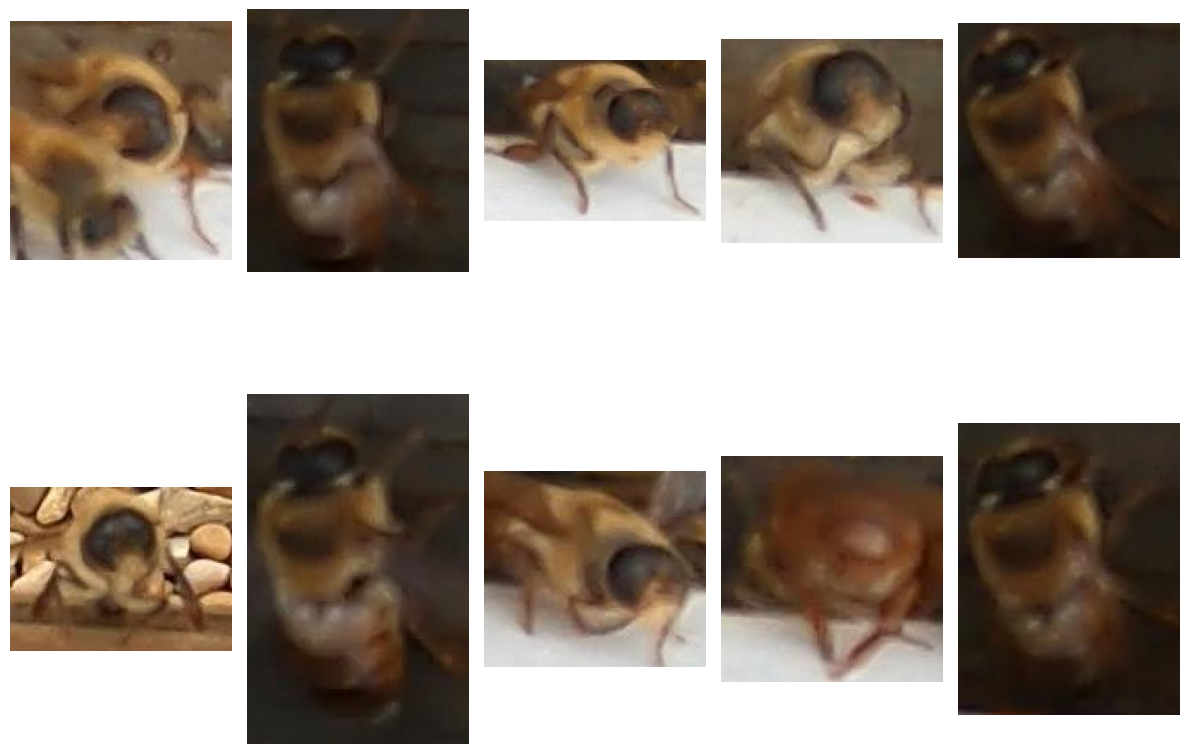

In [107]:
N = len(drone_crops)
cols = 5
rows = 2
show_count = min(10, N)

plt.figure(figsize=(12, 10))

for i in range(show_count):
    plt.subplot(rows, cols, i+1)
    plt.imshow(cv2.cvtColor(drone_crops[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.tight_layout()
plt.show()


**Augmented the cropped drones:**

In [120]:
CROP_DIR = Path("/content/drone_crops_original")
AUG_DIR = Path("/content/drone_crops_augmented")
AUG_DIR.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=25, border_mode=cv2.BORDER_REFLECT),
    A.RandomBrightnessContrast(p=0.4),
    A.GaussNoise(var_limit=(5, 15), p=0.25)
])

idx = 0
for img_path in CROP_DIR.glob("*.jpg"):
    img = cv2.imread(str(img_path))
    for i in range(4):  # create 4 augments per crop
        augmented = transform(image=img)["image"]
        cv2.imwrite(str(AUG_DIR / f"aug_{idx:06d}.jpg"), augmented)
        idx += 1

print("Augmented images saved:", idx)


Augmented images saved: 1332


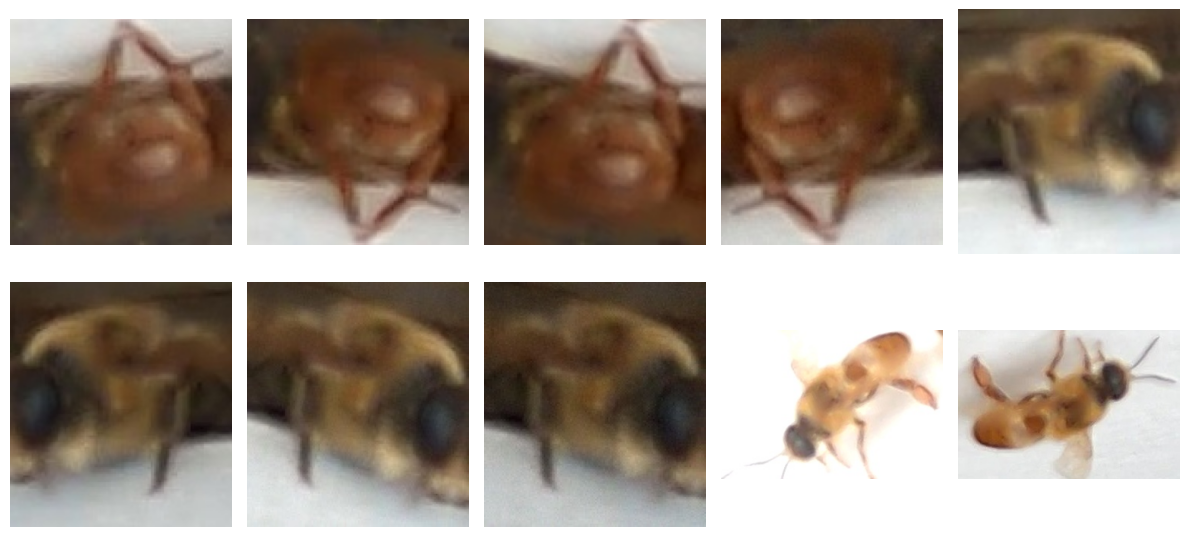

In [121]:
AUG_DIR = Path("/content/drone_crops_augmented")

files = sorted(AUG_DIR.glob("*.jpg"))[:10]   # only first 10

plt.figure(figsize=(12, 6))

for i, fp in enumerate(files):
    img = cv2.imread(str(fp))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Increasing minority class till ratio 2:1

In [122]:
worker_count = 0
drone_count = 0

for split in ["train"]:
    for lbl_file in (base/split/"labels").glob("*.txt"):
        labels = [line.split()[0] for line in open(lbl_file)]
        worker_count += labels.count("0")
        drone_count  += labels.count("1")

print("Workers:", worker_count)
print("Drones:", drone_count)

Workers: 6318
Drones: 468


In [123]:
target_drones = worker_count // 2
needed = target_drones - drone_count
print("Need additional drones:", needed)

Need additional drones: 2691


In [124]:
import cv2
import random
from pathlib import Path

output_img = base / "train" / "images"
output_lbl = base / "train" / "labels"

source_drones = list(CROP_DIR.glob("*.jpg"))
train_images = list(output_img.glob("*.jpg"))

# Calculate drones per image needed
drones_per_image = (needed // len(train_images)) + 1
print(f"Will try to add ~{drones_per_image} drones per image")

added = 0

for target_img_path in train_images:
    if added >= needed:
        break

    target_img = cv2.imread(str(target_img_path))
    h_target, w_target = target_img.shape[:2]

    # Get corresponding label file
    lbl_path = output_lbl / target_img_path.with_suffix(".txt").name

    # Read existing bboxes to avoid overlap
    existing_bboxes = []
    if lbl_path.exists():
        with open(lbl_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls, xc, yc, w, h = parts
                    existing_bboxes.append({
                        'x': float(xc) * w_target,
                        'y': float(yc) * h_target,
                        'w': float(w) * w_target,
                        'h': float(h) * h_target
                    })

    # Track NEW drones separately
    new_drones = []

    # Try to add multiple drones to this image
    drones_added_to_image = 0
    attempts = 0
    max_attempts = drones_per_image * 20

    while drones_added_to_image < drones_per_image and added < needed and attempts < max_attempts:
        attempts += 1

        # Pick and augment a drone
        drone_img = cv2.imread(str(random.choice(source_drones)))
        augmented_drone = transform(image=drone_img)["image"]
        h_drone, w_drone = augmented_drone.shape[:2]

        # Skip if drone too large
        if h_drone >= h_target * 0.8 or w_drone >= w_target * 0.8:
            continue

        # Try random position
        x = random.randint(0, w_target - w_drone)
        y = random.randint(0, h_target - h_drone)

        # Check overlap with ALL bboxes (existing + new drones)
        all_bboxes = existing_bboxes + new_drones
        overlap = False

        for bbox in all_bboxes:
            bbox_x1 = bbox['x'] - bbox['w']/2
            bbox_x2 = bbox['x'] + bbox['w']/2
            bbox_y1 = bbox['y'] - bbox['h']/2
            bbox_y2 = bbox['y'] + bbox['h']/2

            drone_x1 = x
            drone_x2 = x + w_drone
            drone_y1 = y
            drone_y2 = y + h_drone

            if not (drone_x2 < bbox_x1 or drone_x1 > bbox_x2 or
                    drone_y2 < bbox_y1 or drone_y1 > bbox_y2):
                overlap = True
                break

        if not overlap:
            # Paste drone
            target_img[y:y+h_drone, x:x+w_drone] = augmented_drone

            # Add to new drones list (in YOLO format directly)
            new_drones.append({
                'x': x + w_drone/2,
                'y': y + h_drone/2,
                'w': w_drone,
                'h': h_drone
            })

            drones_added_to_image += 1
            added += 1

    # Save modified image
    cv2.imwrite(str(target_img_path), target_img)

    # Append ONLY the new drones to label file
    if drones_added_to_image > 0:
        # Read existing labels
        existing_lines = []
        if lbl_path.exists():
            with open(lbl_path, "r") as f:
                existing_lines = [line.rstrip('\n') for line in f]

        # Write everything back with new drones
        with open(lbl_path, "w") as f:
            # Write existing labels
            for line in existing_lines:
                f.write(line + '\n')

            # Write new drones
            for drone in new_drones:
                x_center = drone['x'] / w_target
                y_center = drone['y'] / h_target
                width = drone['w'] / w_target
                height = drone['h'] / h_target
                f.write(f"1 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Added {drones_added_to_image} drones to {target_img_path.name}")

print(f"\nTotal added: {added} drones across {len(train_images)} images")

Will try to add ~4 drones per image
Added 4 drones to GH010991_MP4_frame_14_tile2_jpg.rf.fe3bd5b252149ad99278382d51b3cc1f.jpg
Added 4 drones to GH010990_MP4_frame_1111_tile0_jpg.rf.59b6c6873515190c7c29964da5834f95.jpg
Added 4 drones to GH010990_MP4_frame_1221_tile0_jpg.rf.29a65b6ff878c10023352ce0f1a71a2f.jpg
Added 4 drones to GH010991_MP4_frame_78_tile0_jpg.rf.53890436f11c8b4ca29d78464529e185.jpg
Added 4 drones to GH010990_MP4_frame_1202_tile0_jpg.rf.e852fa747073ffaadcaf78ad1f1dbf84.jpg
Added 4 drones to GH010991_MP4_frame_63_tile1_jpg.rf.b0b521c5551555efec2d0618862b539a.jpg
Added 4 drones to GH010990_MP4_frame_1009_tile0_jpg.rf.2e7147f65fc9ef92332e192ca28a05fb.jpg
Added 4 drones to GH010990_MP4_frame_965_tile1_jpg.rf.c144946c43802f1e471689564e103600.jpg
Added 4 drones to GH010990_MP4_frame_1187_tile0_jpg.rf.a0dd1dd6f1e3a0099870a6ab5aac0157.jpg
Added 4 drones to GH010990_MP4_frame_961_tile1_jpg.rf.0a6ffbe55016e64b2c8d3f7c33020bee.jpg
Added 4 drones to GH010990_MP4_frame_1163_tile0_jpg.

In [125]:
worker_count = 0
drone_count = 0

for split in ["train"]:
    for lbl_file in (base/split/"labels").glob("*.txt"):
        labels = [line.split()[0] for line in open(lbl_file)]
        worker_count += labels.count("0")
        drone_count  += labels.count("1")

print("Workers:", worker_count)
print("Drones:", drone_count)

Workers: 6318
Drones: 3159


**Double check whether we meet the ratio**, if not then just run again the code

In [126]:
target_drones = worker_count // 2
needed = target_drones - drone_count
print("Still need:", needed, "more drones")

Still need: 0 more drones
